In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/notebooks


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from corner import corner
from matplotlib import pyplot as plt

# hodgkin-huxley
from sourcerer.utils import scale_tensor
from sourcerer.hh_simulator import EphysModel # hh simulator
from sourcerer.hh_utils import HHSurro, PRIOR_MAX, PRIOR_MIN, DEF_RESTRICTED

from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
)
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform, # a little slanted uniform to make log-density well defined
    VariableTemperedUniform,
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores

# other simulators
from sourcerer.simulators import (
    InverseKinematicsSimulator,
    LotkaVolterraSimulator,
    SIRSimulator,
    SLCPSimulator,
    TwoMoonsSimulator,
    GaussianMixtureSimulator,
)

# wasserstein source
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.wasserstein_estimator import train_source

# saving utils
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')
print(f"using {device}")

run id: 20250111_103217
using cuda


In [9]:
0.00001 == 1e-5, 0.0005 == 5e-4

(True, True)

In [10]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    "base.tag=debug",
    "base.folder=sequential_hh",
    "source=wasserstein_hh",
    "source.fin_lambda=0.25",
    "surrogate=hh_train_surrogate", #load_hh_surrogate
    # "surrogate.ydim=5",
    # "surrogate.surrogate_path=./hh_surrogate_epochs_100.pt",
]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

base:
  tag: debug
  folder: sequential_hh
  base_path: ./results_sourcerer
  seed: null
simulator:
  self: inverse_kinematics
  box_domain_lower: -3.141592653589
  box_domain_upper: 3.141592653589
surrogate:
  self: hh_train_surrogate
  num_training_samples: 1000000
  xdim: 13
  ydim: 9
  num_hidden_layers: 4
  hidden_layer_dim: 256
  nb_epochs: 250
  surrogate_lr: 0.0005
  surrogate_weight_decay: 1.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein_hh
  xo_path: TODO_path_to_observations.pkl
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 2000
  linear_decay_steps: 2000
  lambda_steps: 11000
  fin_lambda: 0.25
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 1000000
sequential:
  self: naive
  total_simulation_budget: 2000
  number_of_iterations: 2
  subsampling: false
  collate_last_iter_d

In [11]:
# set seed
if cfg.base.seed is None:
    random_random_seed = np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 55022


In [13]:
cfg.surrogate

{'self': 'hh_train_surrogate', 'num_training_samples': 1000000, 'xdim': 13, 'ydim': 9, 'num_hidden_layers': 4, 'hidden_layer_dim': 256, 'nb_epochs': 250, 'surrogate_lr': 0.0005, 'surrogate_weight_decay': 1e-05, 'early_stopping_patience': 50}

In [23]:
14999995/10**6

14.999995

## load data
note: here we are not using the simulator (also hh simulator takes a fairly long-ish time!), but instead using already generated data

## purpose of the data
- so data has $\approx$ 15M `theta` and `x` pairs already simulated from the HH simulator
- when doing the sequential method, we update our HHsurrogate at each iteration, then sample `theta`s from the source at that point, and call the simulator on it to get the corresponding `x`s and hence prepare the training data to update the surrogate for the next round
- but the HH simulator takes a long time!!

In [16]:
def fetch_hh_data_full(path='./full_batch.npz'):
    sim_data = np.load(path)
    theta = sim_data["theta"]
    stats = sim_data["stats"]

    # Remove undefined simulations (either only the 5 out of 15mil that completelly fail, or the ones without undefined stats)
    keeping = (~np.isnan(np.mean(stats, axis=1))) & (~np.isinf(np.mean(stats, axis=1)))
    moment_keeping = (~np.isnan(stats[:, 22])) & (~np.isinf(stats[:, 22]))  # 22 is a moment
    # print(theta[~moment_keeping, :])  # 5 sims out of 15mil completely fail

    stats = stats[moment_keeping, :]  # delete Nan simulations that completely fail
    theta = theta[moment_keeping, :]  # delete Nan simulations that completely fail
    
    stats = stats[:, DEF_RESTRICTED]
    # reverse engineer unnecessarily undefined counts
    stats[:, :1][np.isnan(stats[:, :1])] = np.log(3)


    # standardization
    source_dim = 13
    # standardize source to range from -1 to 1
    source = scale_tensor(
        torch.from_numpy(np.float32(theta)),
        PRIOR_MIN,
        PRIOR_MAX,
        -torch.ones(source_dim),
        torch.ones(source_dim),
    )
    
    stats_torch = torch.from_numpy(np.float32(stats))
    stats_mean = torch.mean(stats_torch, dim=0)
    stats_std = torch.std(stats_torch, dim=0)
    print(stats_mean)
    print(stats_std)
    stats_torch = (stats_torch - stats_mean) / stats_std
    
    return source, stats_torch

In [17]:
params, xs = fetch_hh_data_full(path='./full_batch.npz') # note that both params and xs are standardized here
print(params.shape, xs.shape)

tensor([  2.3515, -93.2345, -52.7112, 278.6640,   0.4425])
tensor([  1.1922,  20.0867,  19.6551, 300.2828,   4.4556])
torch.Size([14999995, 13]) torch.Size([14999995, 5])


In [19]:
cfg.surrogate.num_training_samples = 100_000 # try with 100k

In [22]:
number_of_sims_surrogate = cfg.surrogate.num_training_samples    # this is the total budget (1_000_000 is too much?)
source      = params[:number_of_sims_surrogate, :] # source in [-1, 1]
stats_torch =     xs[:number_of_sims_surrogate, :] # xs mean 0, var 1
print(number_of_sims_surrogate)#, source.shape, stats_torch.shape)

100000


In [24]:
# # Load data assuming the order here is sufficiently random
# sim_data = np.load("./full_batch.npz")
# theta = sim_data["theta"]
# stats = sim_data["stats"]

# # Remove undefined simulations (either only the 5 out of 15mil that completelly fail, or the ones without undefined stats)
# keeping = (~np.isnan(np.mean(stats, axis=1))) & (~np.isinf(np.mean(stats, axis=1)))

# moment_keeping = (~np.isnan(stats[:, 22])) & (~np.isinf(stats[:, 22]))  # 22 is a moment
# print(theta[~moment_keeping, :])  # 5 sims out of 15mil completely fail

# stats = stats[moment_keeping, :]  # delete Nan simulations that completely fail
# theta = theta[moment_keeping, :]  # delete Nan simulations that completely fail

# stats = stats[:, DEF_RESTRICTED]
# # reverse engineer unnecessarily undefined counts
# stats[:, :1][np.isnan(stats[:, :1])] = np.log(3)

# number_of_sims = 60_000 # 1_000_00 #1_000_000
# stats = stats[:number_of_sims, :]
# theta = theta[:number_of_sims, :]
# keeping = keeping[:number_of_sims]

In [25]:
# stats.shape, theta.shape

In [26]:
# np.where(np.isnan(np.mean(stats, axis=1)))

In [27]:
# keeping.sum(), moment_keeping.sum()

- this is standardizing the parameters

In [28]:
# source_dim = 13
# # standardize source to range from -1 to 1
# source = scale_tensor(
#     torch.from_numpy(np.float32(theta)),
#     PRIOR_MIN,
#     PRIOR_MAX,
#     -torch.ones(source_dim),
#     torch.ones(source_dim),
# )
# print(source.shape) # thus we are calling standardized theta as "source" here

# # %%
# # move res to torch and standardize
# stats_torch = torch.from_numpy(np.float32(stats))
# stats_mean = torch.mean(stats_torch, dim=0)
# stats_std = torch.std(stats_torch, dim=0)
# print(stats_mean)
# print(stats_std)
# stats_torch = (stats_torch - stats_mean) / stats_std

In [29]:
print(source.shape)
print(f'range of params: {source.min().item()} to {source.max().item()}')

torch.Size([100000, 13])
range of params: -0.9999980926513672 to 0.9999983310699463


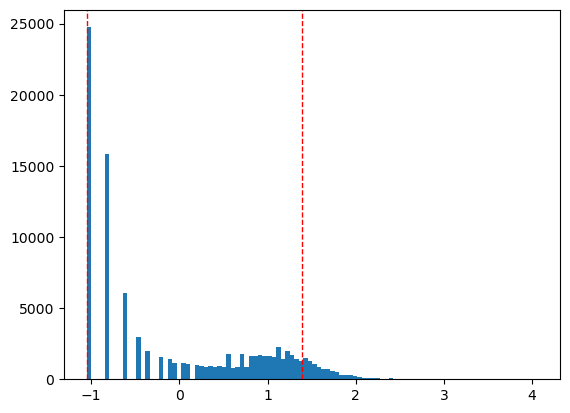

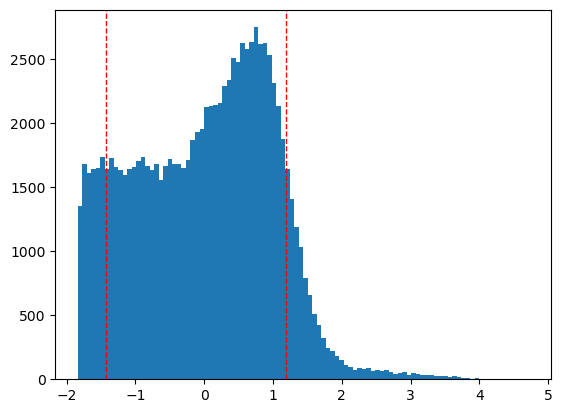

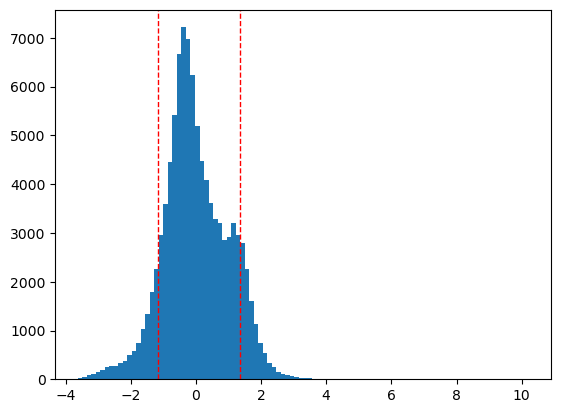

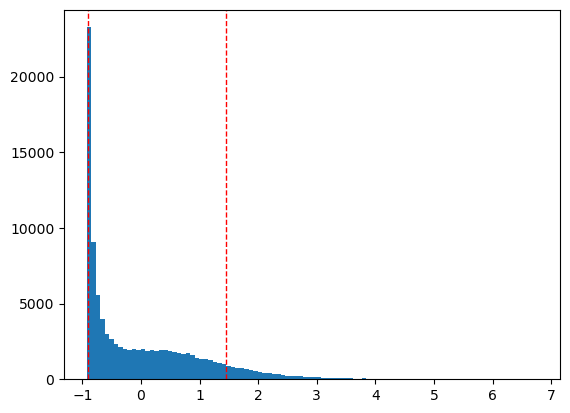

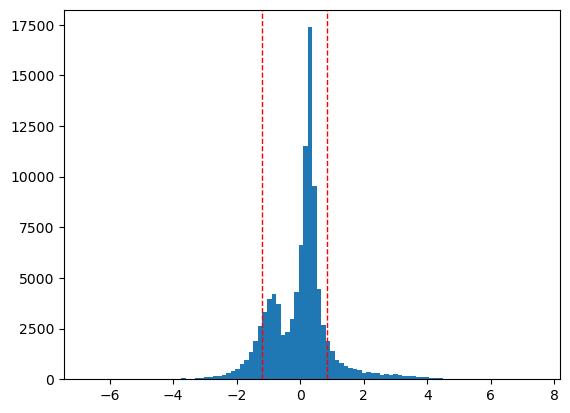

In [30]:
for i in range(stats_torch.shape[1]):
    plt.hist(stats_torch.numpy()[:, i], bins=100)
    plt.axvline(
        np.percentile(stats_torch.numpy()[:, i], 10),
        color="red",
        linestyle="--",
        linewidth=1,
    )
    plt.axvline(
        np.percentile(stats_torch.numpy()[:, i], 90),
        color="red",
        linestyle="--",
        linewidth=1,
    )
    plt.show()

In [31]:
# for i in range(stats_torch.shape[1]):
#     plt.hist(stats_torch.numpy()[:, i], bins=100)
#     plt.axvline(
#         np.percentile(stats_torch.numpy()[:, i], 10),
#         color="red",
#         linestyle="--",
#         linewidth=1,
#     )
#     plt.axvline(
#         np.percentile(stats_torch.numpy()[:, i], 90),
#         color="red",
#         linestyle="--",
#         linewidth=1,
#     )
#     plt.show()

## notes
- this is a deterministic MLP surrogate, i.e., it is trained on MSE loss (while other surrogates are true flow based conditional density estimators)
- 

## initialize simulator (might be unused if we decide to use the nearest neighbour approach)

In [35]:
M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=None,
    noise_factor=10,
)

In [ ]:
def simulate_from_prior(hh_simulator, prior, num_obs):
    
    prior_samples = prior.sample(num_obs)
    simu_box_pf = hh_simulator.simulation_wrapper(prior_samples)

    simu_box_pf_np = simu_box_pf.numpy()
    # same procedure as above (this is a bit messy)
    simu_box_pf_np = simu_box_pf.numpy()
    
    strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
    print(np.sum(strict_keeping_box))
    
    def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
    
    def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
    print(np.sum(def_keeping_box))
    def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
    def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
    print(np.sum(def_keeping_box))

In [ ]:
## this is the initial distribution to sample theta from to train the surrogate
box_domain = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)


In [36]:
# # Plot some traces from simulated pushforward of reference box prior
# num_xo = 10_000
# prior = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
# prior_samples = prior.sample(num_xo)

# simu_box_pf = M1_model.simulation_wrapper(prior_samples)

# # same procedure as above (this is a bit messy)
# simu_box_pf_np = simu_box_pf.numpy()

# strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
# print(np.sum(strict_keeping_box))

# def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]

# def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
# print(np.sum(def_keeping_box))
# def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
# def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
# print(np.sum(def_keeping_box))

## initialize surrogate

In [33]:
cfg.surrogate.ydim = 5
cfg.surrogate

{'self': 'hh_train_surrogate', 'num_training_samples': 100000, 'xdim': 13, 'ydim': 5, 'num_hidden_layers': 4, 'hidden_layer_dim': 256, 'nb_epochs': 250, 'surrogate_lr': 0.0005, 'surrogate_weight_decay': 1e-05, 'early_stopping_patience': 50}

In [34]:
# Define surrogate model
# surrogate = HHSurro(hidden_layer_dim=256, xdim=13, ydim=5).to(device) # hardcoded
# optimizer = optim.Adam(surrogate.parameters(), lr=5e-4, weight_decay=1e-5)
surrogate = HHSurro(hidden_layer_dim=cfg.surrogate.hidden_layer_dim,
                    xdim=cfg.surrogate.xdim,
                    ydim=cfg.surrogate.ydim
                   ).to(device)

optimizer = optim.Adam(surrogate.parameters(),
                       lr=cfg.surrogate.surrogate_lr, # 5e-4
                       weight_decay=cfg.surrogate.surrogate_weight_decay # 1e-5
                      )

assert cfg.surrogate.self == 'hh_train_surrogate'

# this will be moved to inside the loop later
training_dataset, validation_dataset = create_train_val_dataloaders(
    y=stats_torch.to(device),
    x=source.to(device),
    batch_size=4096,
    validation_size=0.2,
    random_state=0,
)

In [37]:
number_of_sims_surrogate

100000

In [38]:
# Train surrogate model with `number_of_sims_surrogate` training samples
training_loss, validation_loss = fit_conditional_normalizing_flow(
    network=surrogate,
    optimizer=optimizer,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    nb_epochs=500, # can afford high nb_epochs if <100k samples are used
    # early_stopping_patience=20,
    early_stopping_patience=10000,
    print_every=50,
)

Epoch: 0, Train Loss: 0.513969250023365, Val Loss: 0.7182732820510864
Epoch: 50, Train Loss: 0.04736855998635292, Val Loss: 0.11724991053342819
Epoch: 100, Train Loss: 0.027593677584081888, Val Loss: 0.11809205710887909
Epoch: 150, Train Loss: 0.019533793535083534, Val Loss: 0.11596778333187104
Epoch: 200, Train Loss: 0.017155581479892136, Val Loss: 0.11012746393680573
Epoch: 250, Train Loss: 0.01588917910121381, Val Loss: 0.11304257810115814
Epoch: 300, Train Loss: 0.01408177511766553, Val Loss: 0.11186227947473526
Epoch: 350, Train Loss: 0.012724113604053854, Val Loss: 0.11276378482580185
Epoch: 400, Train Loss: 0.011063262308016419, Val Loss: 0.11014230400323868
Epoch: 450, Train Loss: 0.011290227947756647, Val Loss: 0.11362431347370147


## save surrogate

In [39]:
torch.save(
    surrogate.state_dict(),
    f"hh_surrogate_epochs_{500}_sims_{number_of_sims_surrogate}.pt",
)

## load surrogate if don't want to train

In [40]:
# # Load surrogate model
# ydim = 5
# surrogate = HHSurro(hidden_layer_dim=256, xdim=13, ydim=ydim).to(device)

# state_dict = torch.load('./hh_surrogate_epochs_250_sims_500000.pt')
# surrogate.load_state_dict(state_dict)
# surrogate = surrogate.to(device)

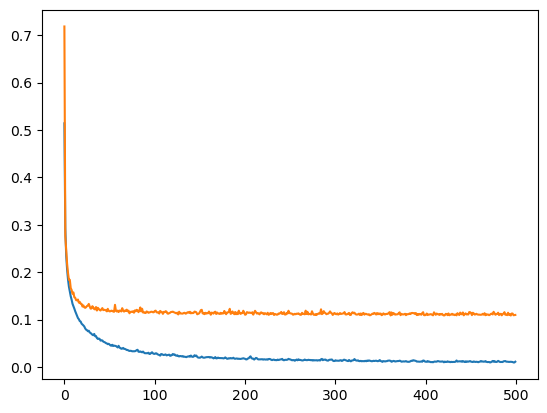

In [41]:
# %%
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()
# %%

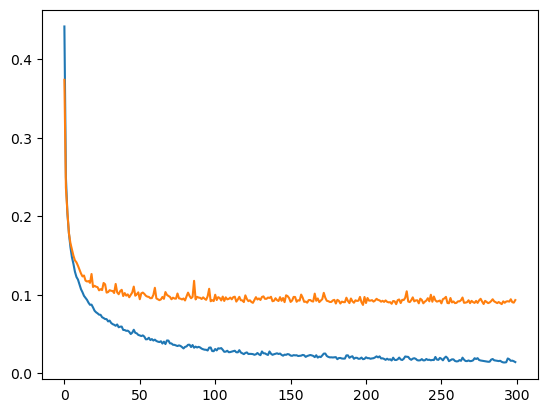

In [18]:
# %%
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()
# %%

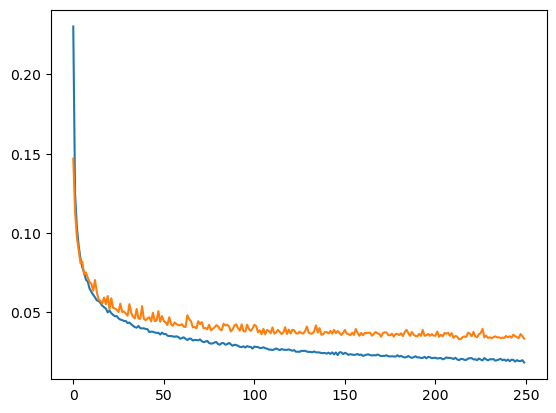

In [79]:
# %%
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()
# %%

In [42]:
surrogate.eval()
with torch.no_grad():
    val_loss = 0.0
    for batch_Y, batch_X in validation_dataset:
        output = surrogate.sample(context=batch_X.to(device))  # forward pass
        loss = surrogate.forward_kld(batch_Y.to(device), batch_X.to(device))
        val_loss += loss.item()

print(val_loss / len(validation_dataset))
print(len(validation_dataset))

0.10966643542051316
5


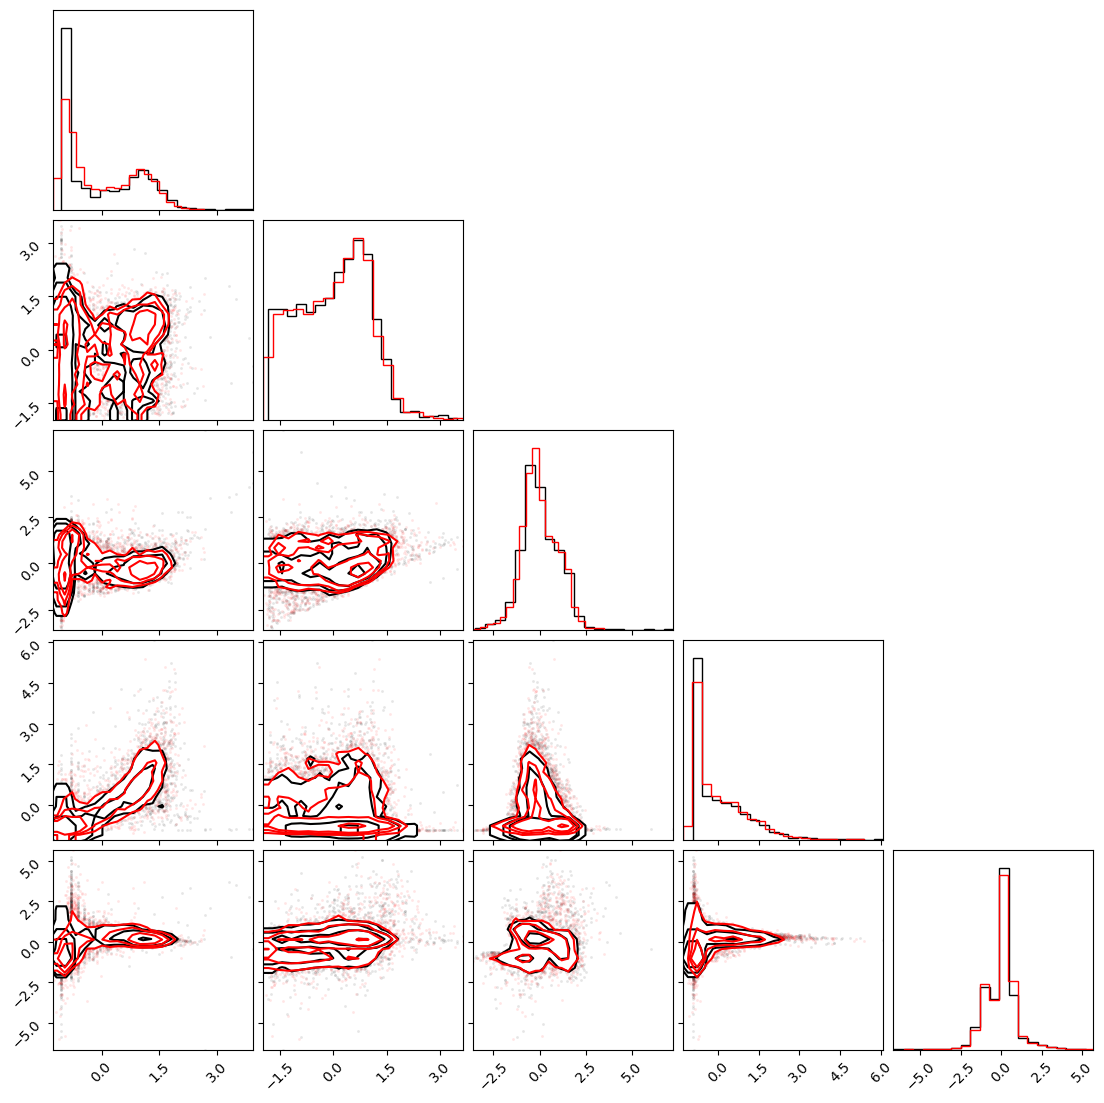

In [43]:
# %%
# Plot surrogate outputs vs. real data.
fig1 = corner(
    batch_Y.cpu().numpy(),
    hist_kwargs={"density": True},
    plot_density=False,
    # plot_contours=False,
)
corner(
    output.cpu().numpy(),
    hist_kwargs={"density": True},
    fig=fig1,
    color="red",
    plot_density=False,
    # plot_contours=False,
)

pass

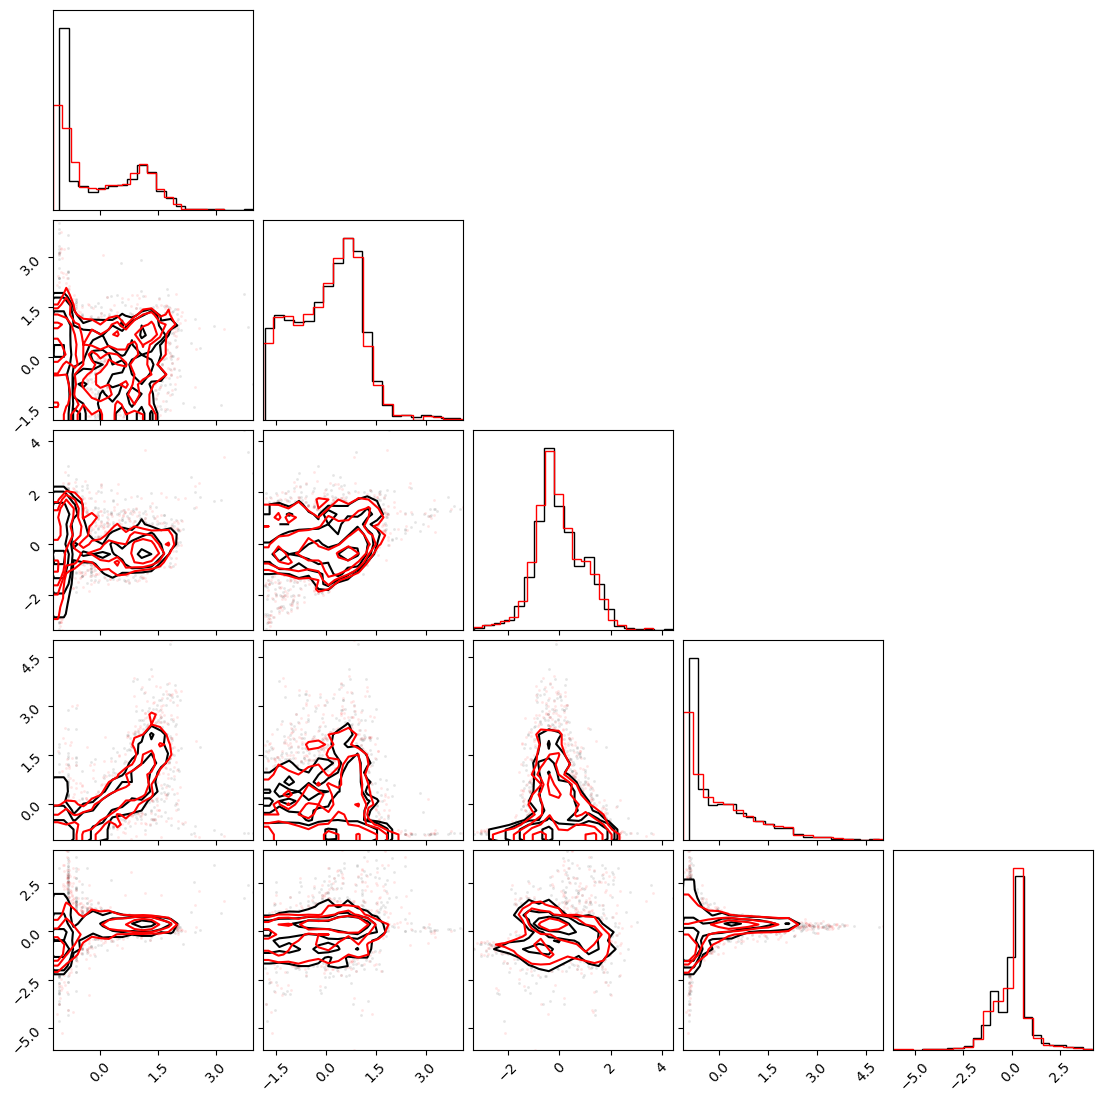

In [19]:
# %%
# Plot surrogate outputs vs. real data.
fig1 = corner(
    batch_Y.cpu().numpy(),
    hist_kwargs={"density": True},
    plot_density=False,
    # plot_contours=False,
)
corner(
    output.cpu().numpy(),
    hist_kwargs={"density": True},
    fig=fig1,
    color="red",
    plot_density=False,
    # plot_contours=False,
)

pass

## surrogate quality metrics like c2st

In [44]:
source.shape, stats_torch.shape

(torch.Size([100000, 13]), torch.Size([100000, 5]))

In [45]:
params.shape, xs.shape

(torch.Size([14999995, 13]), torch.Size([14999995, 5]))

In [48]:
# number_of_sims = 0
gt_source = params[number_of_sims_surrogate:number_of_sims_surrogate+10_000, :] # 10k thetas from true source distribution
gt_source_two = params[number_of_sims_surrogate+10_000:number_of_sims_surrogate+20_000, :] # 10k thetas from true source distribution

gt_simulator = xs[number_of_sims_surrogate:number_of_sims_surrogate+10_000, :]
gt_simulator_two = xs[number_of_sims_surrogate+10_000:number_of_sims_surrogate+20_000, :]

gt_source.shape, gt_simulator.shape

(torch.Size([10000, 13]), torch.Size([10000, 5]))

In [49]:
expected_distance = sliced_wasserstein_distance(
    gt_simulator.to(device),     # from theta1
    gt_simulator_two.to(device), # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()
print(f"Sliced wassertein distance on groundtruth y (expected/baseline swd): {expected_distance}, log: {np.log(expected_distance)}")

Sliced wassertein distance on groundtruth y (expected/baseline swd): 0.03212139382958412, log: -3.438232996399754


In [50]:
surrogate.eval()
with torch.no_grad():
    # surrogate generated observations from the above 2 sets of 10k thetas
    gt_surrogate = surrogate.sample(context=gt_source.to(device))  # forward pass
    gt_surrogate_two = surrogate.sample(context=gt_source_two.to(device))

current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
current_swd = sliced_wasserstein_distance(gt_simulator.to(device), gt_surrogate,
                                          num_projections=4096,
                                          device=device
                                         ).item()
print(f"Surrogate vs Simulator y-space C2ST AUC: {current_c2st}")
print(f"Surrogate vs Simulator y-space SWD AUC: {current_swd}")

Surrogate vs Simulator y-space C2ST AUC: 0.78415
Surrogate vs Simulator y-space SWD AUC: 0.052575960755348206


## c2st on more samples

In [51]:
# this samples were part of training data
gt_source_left = params[:10_000, :]
gt_simulator_left = xs[:10_000, :]

print(gt_source_left.shape, gt_simulator_left.shape)

surrogate.eval()
with torch.no_grad():
    # surrogate generated observations
    gt_surrogate_left = surrogate.sample(context=gt_source_left.to(device))  # forward pass

current_c2st = np.mean(c2st_scores(gt_simulator_left.cpu(), gt_surrogate_left.cpu()))
current_swd = sliced_wasserstein_distance(gt_simulator_left.to(device), gt_surrogate_left,
                                          num_projections=4096,
                                          device=device
                                         ).item()
print(f"Surrogate vs Simulator y-space C2ST AUC: {current_c2st}")
print(f"Surrogate vs Simulator y-space SWD AUC: {current_swd}")

torch.Size([10000, 13]) torch.Size([10000, 5])
Surrogate vs Simulator y-space C2ST AUC: 0.7539999999999999
Surrogate vs Simulator y-space SWD AUC: 0.027506863698363304


In [53]:
gt_source_left = params[number_of_sims_surrogate+50_000:number_of_sims_surrogate+90_000, :]
gt_simulator_left = xs[number_of_sims_surrogate+50_000:number_of_sims_surrogate+90_000, :]

print(gt_source_left.shape, gt_simulator_left.shape)

surrogate.eval()
with torch.no_grad():
    # surrogate generated observations
    gt_surrogate_left = surrogate.sample(context=gt_source_left.to(device))  # forward pass

current_c2st = np.mean(c2st_scores(gt_simulator_left.cpu(), gt_surrogate_left.cpu()))
current_swd = sliced_wasserstein_distance(gt_simulator_left.to(device), gt_surrogate_left,
                                          num_projections=4096,
                                          device=device
                                         ).item()
print(f"Surrogate vs Simulator y-space C2ST AUC: {current_c2st}")
print(f"Surrogate vs Simulator y-space SWD AUC: {current_swd}")

torch.Size([40000, 13]) torch.Size([40000, 5])
Surrogate vs Simulator y-space C2ST AUC: 0.8332375000000001
Surrogate vs Simulator y-space SWD AUC: 0.05849156528711319


In [54]:
surrogate

HHSurro(
  (mse): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [55]:
# %%
rand_id = np.random.randint(0, batch_Y.shape[0])
print(batch_Y[rand_id, :])
print(output[rand_id, :])

print("aggregate")
print(torch.mean(torch.abs(batch_Y - output), dim=0))
print(torch.mean(batch_Y - output, dim=0))
print(torch.std(torch.abs(batch_Y - output), dim=0))



tensor([-0.8096,  1.5855,  1.5153, -0.1775,  0.0386], device='cuda:0')
tensor([-1.1634,  1.7124,  1.3304, -0.0579,  0.0898], device='cuda:0')
aggregate
tensor([0.1935, 0.0768, 0.1055, 0.1651, 0.2274], device='cuda:0')
tensor([-0.0069, -0.0062,  0.0121, -0.0223,  0.0035], device='cuda:0')
tensor([0.3480, 0.1137, 0.1690, 0.2636, 0.3898], device='cuda:0')


In [57]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Jan 11 11:47:15 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:25:00.0 Off |                    0 |
| N/A   34C    P0              48W / 250W |    591MiB / 40960MiB |     44%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [60]:
# # Define config
# # NOTE: These overrides only take effect if this script is run interactively
# local_overrides = [
#     "base.tag=debug",
#     "base.folder=misc",
#     "source=wasserstein_hh",
#     "source.fin_lambda=0.25",
#     "surrogate=load_hh_surrogate",
#     "surrogate.ydim=5",
#     # "surrogate.surrogate_path=../results_sourcerer/surrogates/hh_surrogate.pt",
#     "surrogate.surrogate_path=./hh_surrogate_epochs_100.pt",
# ]

# cfg = script_or_command_line_cfg(
#     config_name="config",
#     config_path="../conf",
#     local_overrides=local_overrides,
#     name=__name__,
# )

# assert cfg.base.tag is not None
# assert cfg.base.folder is not None

# print(OC.to_yaml(cfg))

# save_cfg_as_yaml(
#     cfg,
#     f"{cfg.base.tag}_cfg.yaml",
#     folder=cfg.base.folder,
#     base_path=cfg.base.base_path,
# )


# if cfg.base.seed is None:
#     random_random_seed = np.random.randint(2**16)
#     set_seed(random_random_seed)
#     save_numpy_csv(
#         np.array([random_random_seed], dtype=int),
#         file_name=f"{cfg.base.tag}_seed.csv",
#         folder=cfg.base.folder,
#         base_path=cfg.base.base_path,
#     )
# else:
#     set_seed(cfg.base.seed)

In [61]:
print(f"theta/parameter dimension: {cfg.surrogate.xdim}")
print(f"x/observation dimension: {cfg.surrogate.ydim}")

theta/parameter dimension: 13
x/observation dimension: 5


In [62]:
cfg.source.xo_path = './full_batch.npz'
cfg.source

{'self': 'wasserstein_hh', 'xo_path': './full_batch.npz', 'wasserstein_slices': 500, 'wasserstein_order': 2, 'use_log_sw': True, 'num_chunks': 1, 'num_kole_samples': 512, 'pretraining_steps': 2000, 'linear_decay_steps': 2000, 'lambda_steps': 11000, 'fin_lambda': 0.25, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stopping_patience': 1000000}

## load data file again but this time for source

In [63]:
# Load data and standardize to same scale as for training.
npz = np.load(cfg.source.xo_path)
print(npz['theta'].shape); print(npz['stats'].shape)
# data = read_pickle(cfg.source.xo_path)
# print(data["X_o"].head())

(15000000, 13)
(15000000, 23)


In [65]:
number_of_sims_surrogate

100000

In [66]:
full_xo_stats_np = npz["stats"]
num_xo = full_xo_stats_np.shape[0]
print(num_xo)

xo_stats_np = full_xo_stats_np[:, DEF_RESTRICTED]
xo_stats_np = xo_stats_np[np.where(~np.isnan(xo_stats_np).any(axis=1))[0]] #remove nan

xo_stats = torch.from_numpy(np.float32(xo_stats_np))

supervised_mean = torch.tensor(
    [  # correct restricted 1 mil
        2.3512,
        -93.2657,
        -52.7358,
        278.4319,
        0.4392,
    ],
)

supervised_std = torch.tensor(
    [  # correct restricted 1 mil
        1.1922,
        20.0920,
        19.6483,
        300.1352,
        4.4579,
    ],
)
xo_stats_norm = (xo_stats - supervised_mean) / supervised_std
# xo_stats_norm = xo_stats_norm.to(device)


# take 1M samples to fit source
number_of_sims_source = 500_000
xo_stats_norm = xo_stats_norm[:number_of_sims_source, :].to(device) # xo_stats_norm lives on GPU!!
print(xo_stats_norm.shape[0])

15000000
500000


In [67]:
xo_stats_norm.shape

torch.Size([500000, 5])

In [68]:
xo_stats_norm.shape[0] / 1e6

0.5

In [69]:
# Define source flows
if cfg.source_model.self == "sampler":
    source = Sampler(
        xdim=cfg.surrogate.xdim,
        input_noise_dim=cfg.surrogate.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=cfg.surrogate.xdim,
        context_dim=0,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

In [70]:
source

Sampler(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=13, bias=True)
  )
)

In [74]:
cfg.source.lambda_steps = 6000
cfg.source

{'self': 'wasserstein_hh', 'xo_path': './full_batch.npz', 'wasserstein_slices': 500, 'wasserstein_order': 2, 'use_log_sw': True, 'num_chunks': 1, 'num_kole_samples': 512, 'pretraining_steps': 2000, 'linear_decay_steps': 2000, 'lambda_steps': 6000, 'fin_lambda': 0.25, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stopping_patience': 1000000}

In [75]:
# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

cfg.source.num_chunks = 1
# cfg.source.num_chunks

schedule = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps * cfg.source.num_chunks),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps * cfg.source.num_chunks,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps * cfg.source.num_chunks),
    ]
)

torch.Size([10000])


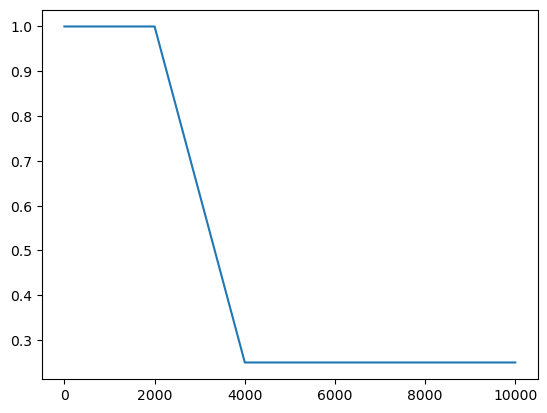

In [76]:
print(schedule.shape)
plt.plot(schedule)

In [ ]:
train_loss = train_source(
    data=xo_stats_norm,  # note that we are passing standardized x-s to fit the source
    source_model=source,
    simulator=surrogate,
    optimizer=optimizer,
    entro_dist=None,
    entro_lambda=schedule,
    wasser_p=cfg.source.wasserstein_order,
    wasser_np=cfg.source.wasserstein_slices,
    use_log_sw=cfg.source.use_log_sw,
    num_chunks=cfg.source.num_chunks,
    epochs=cfg.source.pretraining_steps
    + cfg.source.linear_decay_steps
    + cfg.source.lambda_steps,
    min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
    early_stopping_patience=cfg.source.early_stopping_patience,
    device=device,
    print_every=1000,
)

Epoch x Chunk: 0, Weighted Loss: 15.973078976026796, Entropy loss: 15.973078976026796, Wasser loss: -0.2254319190979004
Epoch x Chunk: 1000, Weighted Loss: 0.31939870377416213, Entropy loss: 0.31939870377416213, Wasser loss: -1.3914363384246826
Epoch x Chunk: 2000, Weighted Loss: 0.21981757651299816, Entropy loss: 0.21981757651299816, Wasser loss: -1.225690245628357
Epoch x Chunk: 3000, Weighted Loss: -1.2785960133001244, Entropy loss: 0.2692231896880042, Wasser loss: -3.8562309741973877
Epoch x Chunk: 4000, Weighted Loss: -3.346628614116098, Entropy loss: 0.3198358700736943, Wasser loss: -4.568783283233643
Epoch x Chunk: 5000, Weighted Loss: -3.5279584353765308, Entropy loss: 0.2132871843971973, Wasser loss: -4.775040149688721
Epoch x Chunk: 6000, Weighted Loss: -3.56387761341022, Entropy loss: 0.34762370163255696, Wasser loss: -4.867711544036865
Epoch x Chunk: 7000, Weighted Loss: -3.6441753612420196, Entropy loss: 0.26080103458514436, Wasser loss: -4.945834159851074


In [ ]:
# train_loss = train_source(
#     data=xo_stats_norm,  # note that we are passing standardized x-s to fit the source
#     source_model=source,
#     simulator=surrogate,
#     optimizer=optimizer,
#     entro_dist=None,
#     entro_lambda=schedule,
#     wasser_p=cfg.source.wasserstein_order,
#     wasser_np=cfg.source.wasserstein_slices,
#     use_log_sw=cfg.source.use_log_sw,
#     num_chunks=cfg.source.num_chunks,
#     epochs=cfg.source.pretraining_steps
#     + cfg.source.linear_decay_steps
#     + cfg.source.lambda_steps,
#     min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
#     early_stopping_patience=cfg.source.early_stopping_patience,
#     device=device,
#     print_every=1000,
# )

Epoch x Chunk: 0, Weighted Loss: 16.003980581036092, Entropy loss: 16.003980581036092, Wasser loss: -0.2251361757516861
Epoch x Chunk: 1000, Weighted Loss: 0.2659637210015333, Entropy loss: 0.2659637210015333, Wasser loss: -1.42173171043396
Epoch x Chunk: 2000, Weighted Loss: 0.057949460924843876, Entropy loss: 0.057949460924843876, Wasser loss: -1.2746632099151611


In [52]:
save_state_dict(
    source,
    f"{cfg.base.tag}_learned_source_{number_of_sims}.pt",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

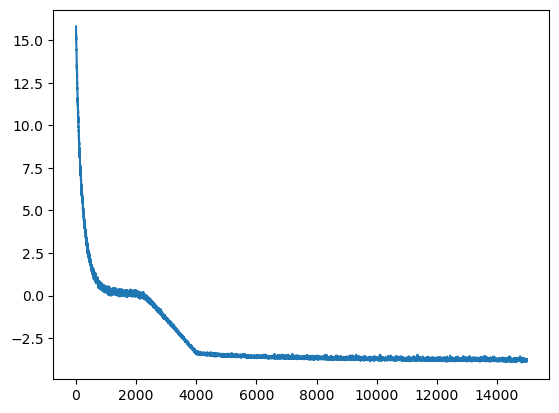

In [53]:
plt.plot(train_loss)
plt.show()

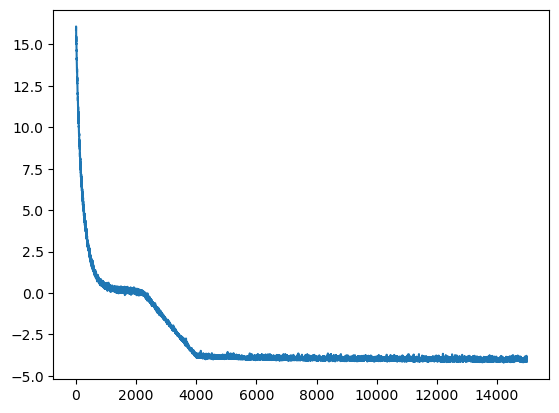

In [100]:
# old run
plt.plot(train_loss)
plt.show()

## source metrics

In [41]:
torch.ones(source_dim, device=device)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [90]:
source_dim=13

# Evaluate trained source model
with torch.no_grad():
    estimated_source = source.sample(10_000)
    moved_estimated_source = scale_tensor(
        estimated_source.cpu(),
        -torch.ones(source_dim),
        torch.ones(source_dim),
        PRIOR_MIN,
        PRIOR_MAX,
    )
    surro_estimated_pf = surrogate.sample(10_000, estimated_source)
    
# here we need nearest neighbours!!!
# simu_estimated_pf = simulator.sample(moved_estimated_source)

In [91]:
params, estimated_source

(tensor([[ 0.7847, -0.4827,  0.5653,  ...,  0.2637, -0.8465,  0.3477],
         [-0.9305,  0.1965, -0.1808,  ..., -0.6925, -0.9380,  0.8117],
         [-0.8324,  0.5970, -0.8636,  ..., -0.1238, -0.4045,  0.2523],
         ...,
         [-0.2127,  0.3745,  0.2680,  ...,  0.6941, -0.1007,  0.0597],
         [ 0.1593, -0.1530, -0.3240,  ...,  0.9808,  0.4618,  0.2155],
         [-0.3169, -0.7861, -0.5055,  ..., -0.1901, -0.3730, -0.2993]]),
 tensor([[-0.6599,  0.0973, -0.6257,  ...,  0.7436,  0.8119, -0.6507],
         [ 0.5183, -0.0449,  0.1498,  ...,  0.5751, -0.0145, -0.8162],
         [ 0.6517, -0.3454,  0.1195,  ..., -0.8579, -0.0369, -0.0639],
         ...,
         [ 0.4424,  0.1595,  0.9273,  ..., -0.1933,  0.7608,  0.8183],
         [-0.1944,  0.8260, -0.5749,  ..., -0.5151,  0.8298,  0.8228],
         [-0.5857,  0.8126,  0.7428,  ...,  0.6683, -0.1450, -0.9000]],
        device='cuda:0'))

In [92]:
((params - estimated_source.cpu()[1])**2).sum(1).argmin()

tensor(13256170)

In [93]:
params[((params - estimated_source.cpu()[1])**2).sum(1).argmin().item()]

tensor([ 0.4578,  0.0205,  0.4847,  0.9478,  0.2527, -0.3710, -0.4782, -0.1871,
        -0.5295, -0.7758,  0.6355,  0.1408, -0.9247])

In [94]:
estimated_source[1]

tensor([ 0.5183, -0.0449,  0.1498,  0.9525,  0.3966, -0.5056, -0.6388, -0.4315,
        -0.3306, -0.7105,  0.5751, -0.0145, -0.8162], device='cuda:0')

In [95]:
# source metrics in terms of pushforwards: Classifier two sample tests
# simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
print(f"y c2st AUC on surrogate: {surro_c2st}")

y c2st AUC on surrogate: 0.62905


In [60]:
# source metrics in terms of pushforwards: Classifier two sample tests
# simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
print(f"y c2st AUC on surrogate: {surro_c2st}")

y c2st AUC on surrogate: 0.6292500000000001


In [61]:
M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=None,
    noise_factor=10,
)

# num_xo = 1000

# prior = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
# prior_samples = prior.sample(num_xo)

In [62]:
simu_box_pf = M1_model.simulation_wrapper(moved_estimated_source) # here we need to pass unnormalized source!!!
simu_box_pf_np = simu_box_pf.numpy()

strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))
def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)

simu_estimated_pf = def_stats_box_np

def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))

9825
10000


In [63]:
gt_simulator_two = xo_stats[150_000+10_000:150_000+20_000, :]

In [64]:
simu_estimated_pf.shape, gt_simulator_two.shape

((10000, 5), torch.Size([10000, 5]))

In [71]:
gt_simulator_two = xo_stats[1_000_000+20_000:1_000_000+30_000, :]

In [72]:
gt_simulator_two.min(), simu_estimated_pf.min(), gt_simulator_two.max(), simu_estimated_pf.max()

(tensor(-130.0352),
 np.float64(-129.96125840530138),
 tensor(2050.7131),
 np.float64(2097.46933801357))

In [73]:
simu_c2st = np.mean(
    c2st_scores(
        torch.from_numpy(simu_estimated_pf),
        gt_simulator_two,
        seed=10,
    )
)
print(f"y c2st AUC on simulator: {simu_c2st}")

y c2st AUC on simulator: 0.5708


In [117]:
simu_c2st = np.mean(
    c2st_scores(
        torch.from_numpy(simu_estimated_pf),
        gt_simulator_two,
        seed=10,
    )
)
print(f"y c2st AUC on simulator: {simu_c2st}")

y c2st AUC on simulator: 0.53515


In [77]:
# gt_simulator_two.device

In [72]:
# swd computation
num_repeat = 1
simu_dists = np.zeros(num_repeat)
for idx in range(10):
    with torch.no_grad():
        # pushforward from simulator on a new & different θ from estimated source
        estimated_source = source.sample(10_000)
        moved_estimated_source = scale_tensor(
            estimated_source.cpu(),
            -torch.ones(source_dim),
            torch.ones(source_dim),
            PRIOR_MIN,
            PRIOR_MAX,
        )
        simu_box_pf = M1_model.simulation_wrapper(moved_estimated_source) # here we need to pass un-normalized source!!!
        simu_box_pf_np = simu_box_pf.numpy()
        strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
        def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]
        def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
        # print(np.sum(def_keeping_box))
        def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
        
        simu_estimated_pf_add = def_stats_box_np
        #simu_est_pf_add = simulator.sample(source.sample(cfg.source.num_eval_obs))
    
    simu_dists[idx] = sliced_wasserstein_distance(
        torch.from_numpy(simu_estimated_pf_add),   # pushforward from simulator using estimated θ
        gt_simulator_two,  # pushforward from simulator using ground truth θ
        num_projections=4096,
        device=device,
    )
simu_swd, simu_swd_std = np.mean(simu_dists), np.std(simu_dists)
print(simu_swd, simu_swd_std)

WARNING    /mnt/qb/work/macke/mwe102/sourcerer-sequential/sourcerer/hh_simulator.py:556: RuntimeWarning: divide by zero encountered in log
  np.log(cv),
 [py.warnings]
  np.log(cv),



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [68]:
# print("Estimate source entropies")
estimated_source_kole = kozachenko_leonenko_estimator(estimated_source, on_torus=False).item()
print(f"Estimated source entropy estimate: {estimated_source_kole}")

Estimated source entropy estimate: 8.739278787414793


## source visualization

In [77]:
xo_stats_np.shape, simu_estimated_pf.shape, gt_simulator_two.shape

((11303553, 5), (10000, 5), torch.Size([10000, 5]))

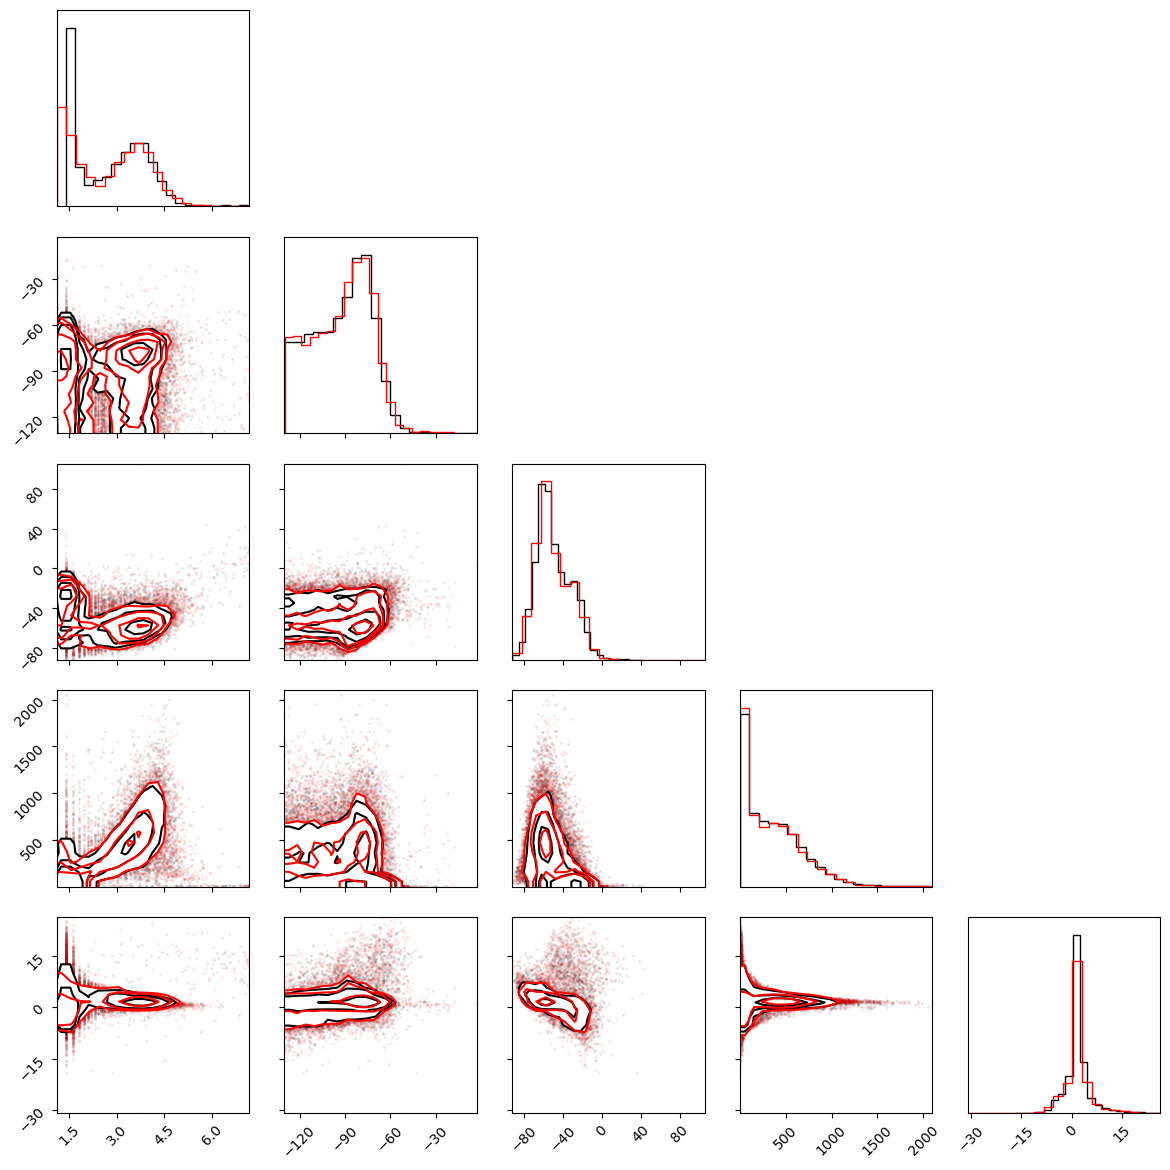

In [78]:
# Plot data with simulator pushforward
fig_simu = corner(
    gt_simulator_two.numpy(),
    color="black",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    simu_estimated_pf,
    fig=fig_simu,
    color="red",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)

save_fig(
    fig_simu,
    file_name=f"{cfg.base.tag}_simulator_fig.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

In [79]:
# Evaluate trained source model
with torch.no_grad():
    estimated_source = source.sample(10_000)
    moved_estimated_source = scale_tensor(
        estimated_source.cpu(),
        -torch.ones(source_dim),
        torch.ones(source_dim),
        PRIOR_MIN,
        PRIOR_MAX,
    )
moved_estimated_source

tensor([[ 1.2043e+01,  9.9515e+02,  6.2817e+01,  ...,  1.3394e+03,
         -4.9425e+01,  2.3625e+00],
        [ 1.0352e+01,  3.8438e+02,  5.9053e+01,  ...,  2.1716e+03,
         -5.8660e+01,  2.0772e+00],
        [ 4.6551e+00,  9.2130e+02,  4.2713e+00,  ...,  8.6054e+02,
         -5.3199e+01,  2.3871e+00],
        ...,
        [ 1.9563e+00,  7.6910e+02,  5.6697e+01,  ...,  1.7921e+03,
         -3.8390e+01,  1.2632e+00],
        [ 1.5141e+00,  4.4849e+02,  2.7397e+01,  ...,  1.5983e+02,
         -8.2385e+01,  2.3775e+00],
        [ 4.9582e+00,  7.3327e+02,  6.5355e+01,  ...,  1.2365e+02,
         -4.6468e+01,  2.3494e+00]])

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4


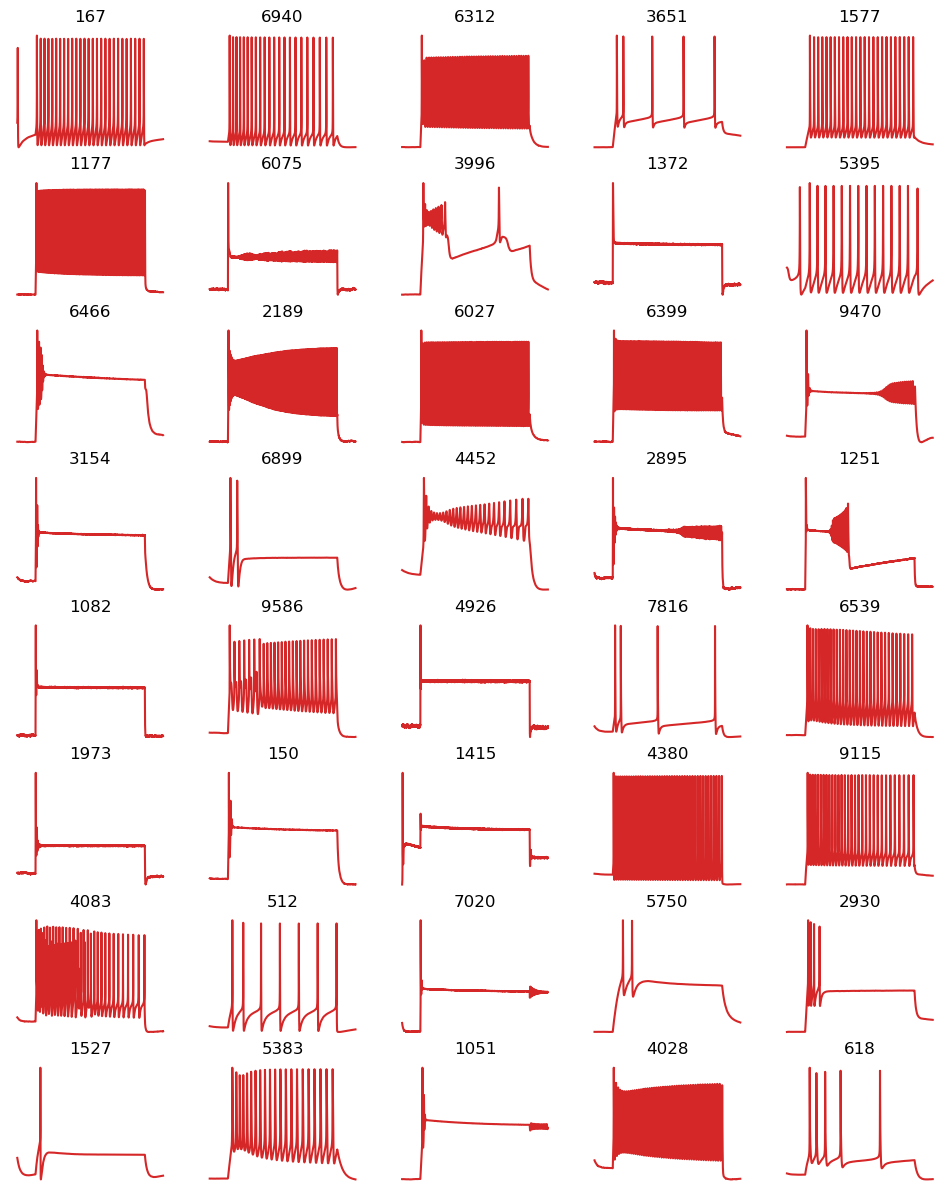

In [82]:
# Plot some traces from simulator pushforward of learned source
fig_samp_source, axs = plt.subplots(8, 5, figsize=(12, 15))
for i in range(8):
    for j in range(5):
        print(i, j)
        rand = np.random.randint(moved_estimated_source.shape[0])
        trial = moved_estimated_source[rand][np.newaxis, :]
        x = M1_model.run_HH_model(trial)
        axs[i, j].plot(x["time"], x["data"][0, 0, :], c="C3")
        axs[i, j].set_title(rand)
        axs[i, j].set_axis_off()

plt.show()




In [84]:
save_fig(
    fig_samp_source,
    file_name=f"{cfg.base.tag}_samp_source_fig.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

In [83]:
# Plot some traces from simulated pushforward of reference box prior
num_xo = 10_000
prior = VariableTemperedUniform(lower_bound=PRIOR_MIN, upper_bound=PRIOR_MAX)
prior_samples = prior.sample(num_xo)

simu_box_pf = M1_model.simulation_wrapper(prior_samples)

# %%
# same procedure as above (this is a bit messy)
simu_box_pf_np = simu_box_pf.numpy()

strict_keeping_box = ~np.isnan(np.mean(simu_box_pf_np, axis=1))
print(np.sum(strict_keeping_box))

def_stats_box_np = simu_box_pf_np[:, DEF_RESTRICTED]

def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))
def_stats_box_np[np.isnan(def_stats_box_np)] = np.log(3)
def_keeping_box = ~np.isnan(np.mean(def_stats_box_np, axis=1))
print(np.sum(def_keeping_box))

4751
7535
10000


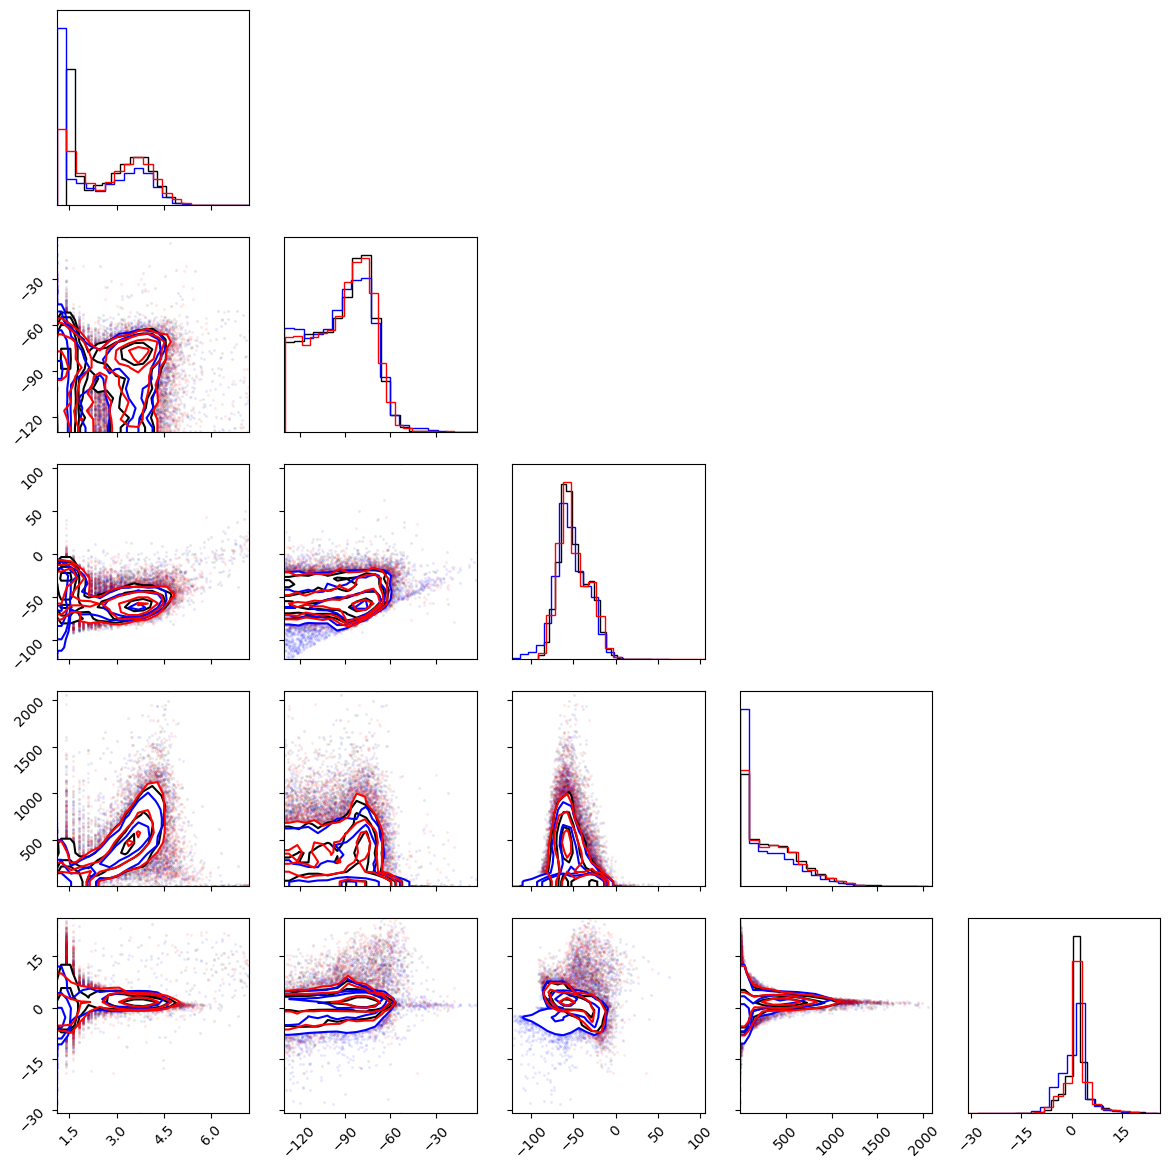

In [85]:
# %%
fig_simu_extend = corner(
    gt_simulator_two.numpy(),
    color="black",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    def_stats_box_np,
    fig=fig_simu_extend,
    color="blue",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)
corner(
    simu_estimated_pf,
    fig=fig_simu_extend,
    color="red",
    bins=20,
    hist_kwargs={"density": True},
    # plot_contours=False,
    plot_density=False,
    # plot_datapoints=False,
)

save_fig(
    fig_simu_extend,
    file_name=f"{cfg.base.tag}_simulator_extended_fig.pdf",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

In [89]:
source

Sampler(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=13, bias=True)
  )
)

In [96]:
# torch.cuda.empty_cache()
!nvidia-smi

Sat Jan 11 00:20:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:C2:00.0 Off |                    0 |
| N/A   31C    P0              37W / 250W |    613MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [66]:
# del xo_stats_norm